In [1]:
from field_importer import get_field
from cartoplot import cartoplot
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
%config Completer.use_jedi = False

In [2]:
monthlist = ["10","11","12","01","02","03","04"]

yearlist = list(range(2003,2019))


month_diffs = {}

for month in monthlist:
    
    yearlist = range(2002,2018) if month in ['10','11','12'] else range(2003,2019)
    
    month_diffs[month] = []

    for year in yearlist:

        M2_SWE = get_field('SnowModel',month,year,resolution=361,variable='M2 depth')
        E5_SWE = get_field('SnowModel',month,year,resolution=361,variable='E5 depth')
        
        diff = (E5_SWE['field'] - M2_SWE['field'])*100
        
        month_diffs[month].append(diff)

In [3]:
month_ave_diffs = {}

for key in month_diffs.keys():
    
    ave = np.mean(month_diffs[key], axis=0)
    
    month_ave_diffs[key] = ave
    

    

In [4]:
region_codes = {
        "Barents":8,
        "Kara":9,
        "Laptev":10,
        "East Siberian":11,
        "Chukchi":12,
        "Beaufort":13,
        "Central Arctic":15}

regions_l = list(region_codes.keys())

In [5]:
month_names = {"10":'Oct',
               "11":'Nov',
               "12":'Dec',
               "01":'Jan',
               "02":'Feb',
               "03":'Mar',
               "04":'Apr',
              }

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


['Barents', 'Kara', 'Laptev', 'East Siberian', 'Chukchi', 'Beaufort', 'Central Arctic']


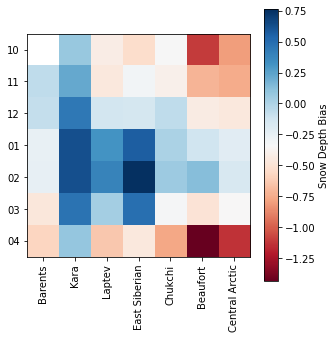

In [6]:
mask_dir = '/home/robbie/Dropbox/Code/mask.nc'
mask_data = Dataset(mask_dir)

lon, lat =np.array(mask_data['lon']), np.array(mask_data['lat'])
my_mask = np.array(mask_data['mask_values'])

regional_diffs = {}

for key in month_ave_diffs:
    
    regional_diffs[key] = {}
    
    for region in regions_l:
        
        region_err = ma.masked_where(my_mask != region_codes[region], month_ave_diffs[key])
        region_err = np.ma.filled(region_err.astype(float), np.nan)
        mean_error = np.nanmean(region_err)
        
        regional_diffs[key][region] = mean_error
        
hmap = np.full((len(regions_l),len(monthlist)),np.nan)

for monthcounter, month in enumerate(monthlist):

    for regioncounter, region in enumerate(regions_l):
        
        hmap[monthcounter,regioncounter] = regional_diffs[month][region]

print(regions_l)
    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xticklabels([""]+regions_l,rotation=90)
ax.set_yticklabels([""]+monthlist)

h = ax.imshow(hmap, cmap='RdBu')
cb = fig.colorbar(h)
cb.set_label('Snow Depth Bias')

In [7]:
print(regional_diffs)

{'10': {'Barents': nan, 'Kara': 0.08093169331550598, 'Laptev': -0.42109380882866326, 'East Siberian': -0.5320344797476038, 'Chukchi': -0.33156292057357545, 'Beaufort': -1.108416877248708, 'Central Arctic': -0.7979828252373651}, '11': {'Barents': -0.061968809390371596, 'Kara': 0.226359115413497, 'Laptev': -0.4550729492634326, 'East Siberian': -0.30779712825455346, 'Chukchi': -0.38919699802742497, 'Beaufort': -0.7113175988778999, 'Central Arctic': -0.7442157897252066}, '12': {'Barents': -0.07893865307798029, 'Kara': 0.4439734712917295, 'Laptev': -0.1319586600913958, 'East Siberian': -0.13986069896824696, 'Chukchi': -0.06004441996531252, 'Beaufort': -0.4304526258878736, 'Central Arctic': -0.4486251106985589}, '01': {'Barents': -0.2519115534896793, 'Kara': 0.6305656989246355, 'Laptev': 0.3192437786966073, 'East Siberian': 0.5680410873571897, 'Chukchi': 0.011369686023918022, 'Beaufort': -0.11705503763579246, 'Central Arctic': -0.2112834689266592}, '02': {'Barents': -0.2502676024255002, 'Kar

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


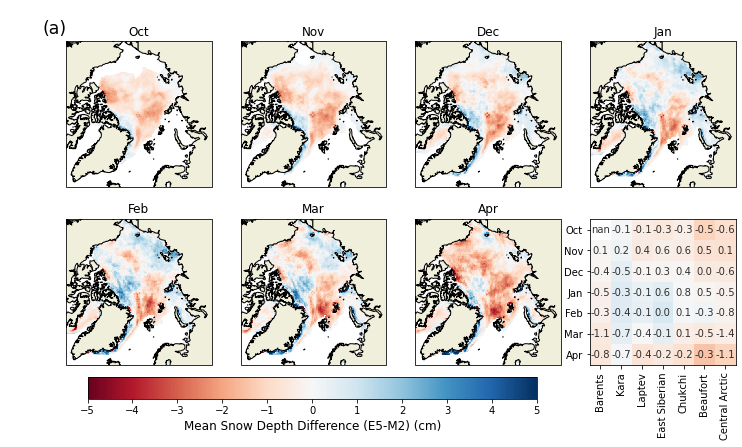

In [20]:
fig = plt.figure(figsize=(12,6))

vmin = -5; vmax = 5 

for counter, key in enumerate(month_ave_diffs.keys()) :
    
    ave = month_ave_diffs[key]
    
    
    ax = fig.add_subplot(2,4,counter+1,projection=ccrs.NorthPolarStereo())

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
    ax.set_title(month_names[key])
    ax.pcolormesh(M2_SWE['lon'], M2_SWE['lat'], ave[:-1,:-1], vmin = vmin, vmax = vmax,
                 transform=ccrs.PlateCarree(),cmap='RdBu')
    
    
ax = fig.add_subplot(2,4,8,)
ax.set_xticks(np.arange(len(regions_l)))
ax.set_xticklabels(regions_l,rotation=90)
ax.set_yticklabels([""]+list(month_names.values()))
h = ax.imshow(hmap, cmap='RdBu', vmin = vmin, vmax = vmax)


for mcount, month in enumerate(monthlist):
    for rcount, region in enumerate(regions_l):
        ax.annotate(f'{np.round(hmap[mcount,rcount],decimals=1)}',
                    xy=(mcount,rcount),
                    color='k',
                    alpha=0.8,
                    xycoords='data', ha='center', va='center',fontsize='medium')

cax = fig.add_axes([0.15, 0.05, 0.52, 0.05])
cb = fig.colorbar(h, cax=cax, orientation='horizontal')
cb.set_label('Mean Snow Depth Difference (E5-M2) (cm)', fontsize='large')
cb.set_ticks(np.arange(-5,6,1))

plt.annotate('(a)', (0.057,0.925), xycoords='figure fraction', fontsize='xx-large')

plt.savefig(f"SM_reanalysis_maps_a.png",
                dpi=450, bbox_inches='tight')